# AWS-RoseTTAFold: Bulk Job Analysis

## I. Introduction

This notebook demonstrates how to analyze multiple protein simultaneously, in this case a subset of the CASP14 target set.

## II. Environment setup

In [1]:
## Install dependencies
!pip install -q -q -r requirements.txt

## Import helper functions at rfutils/rfutils.py
from rfutils import rfutils

## Load additional dependencies
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import boto3
import glob
import json
from IPython.display import display
import pandas as pd
import sagemaker

pd.set_option("max_colwidth", None)

# Get service clients
session = boto3.session.Session()
sm_session = sagemaker.session.Session()
region = session.region_name
role = sagemaker.get_execution_role()
s3 = boto3.client("s3", region_name=region)
account_id = boto3.client("sts").get_caller_identity().get("Account")

bucket = sm_session.default_bucket()

## III. Input Protein Sequence

Download and process CASP14 sequences

In [2]:
!wget "https://predictioncenter.org/download_area/CASP14/sequences/casp14.seq.txt" -O "data/casp14.fa"
!sed '137,138d' "data/casp14.fa" > "data/casp14_dedup.fa" # Remove duplicate entry for T1085

casp14_iterator = SeqIO.parse("data/casp14_dedup.fa", "fasta")
casp14_df = pd.DataFrame(
    (
        (record.id, record.description, len(record), record.seq)
        for record in casp14_iterator
    ),
    columns=["id", "description", "length", "seq"],
).sort_values(by="length")
!rm data/casp14*

--2021-12-10 17:24:48--  https://predictioncenter.org/download_area/CASP14/sequences/casp14.seq.txt
Resolving predictioncenter.org (predictioncenter.org)... 128.120.136.155
Connecting to predictioncenter.org (predictioncenter.org)|128.120.136.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31420 (31K) [text/plain]
Saving to: ‘data/casp14.fa’

data/casp14.fa      100%[===================>]  30.68K  --.-KB/s    in 0.1s    

2021-12-10 17:24:49 (258 KB/s) - ‘data/casp14.fa’ saved [31420/31420]



Display information about CASP14 proteins

In [3]:
with pd.option_context("display.max_rows", None):
    display(casp14_df.loc[:, ("id", "description")])

,id,description
38,T1059,"T1059 MtrunA17_Chr7g0216231, Medicago truncatula, 32 residues|"
42,T1062,"T1062 T5 phage tail subcomplex, T5 phage, 35 residues|"
56,T1072s2,"T1072s2 Q6PIF2, Q9BXU0, Homo sapiens, subunit 2, 69 residues|"
67,T1084,"T1084 Meio, Meiothermus silvanus, 73 residues|"
23,T1046s1,"T1046s1 RI-T complex, , subunit 1, 74 residues|"
70,T1087,"T1087 Tuna, Methylobacter tundripaludum, 93 residues|"
7,T1031,"T1031 S0A2C3d1, , 95 residues|"
65,T1082,"T1082 gp63, T4 phage, 97 residues|"
66,T1083,"T1083 Nitro, Nitrosococcus oceani, 98 residues|"
46,T1065s2,"T1065s2 N4-Cytosine Methyltransferase, Serratia marcescens, subunit 2, 98 residues|"


Plot distribution of the protein lengths

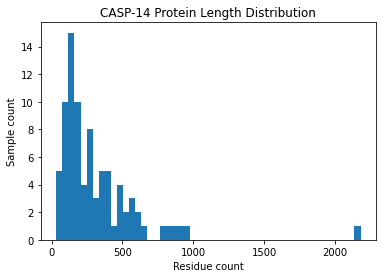

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.hist(casp14_df.length, bins=50)
plt.ylabel("Sample count")
plt.xlabel("Residue count")
plt.title("CASP-14 Protein Length Distribution")
plt.show()

Get the names of the AWS Batch resources deployed in your account.

In [7]:
batch_resources = rfutils.get_rosettafold_batch_resources()
batch_resources

type,dataPrepJobDefinition,dataPrepJobQueue,predictJobDefinition,predictJobQueue
stackId,,,,
0a7c76781505,aws-rosettafold-job-def-cpu-0a7c76781505,aws-rosettafold-queue-cpu-0a7c76781505,aws-rosettafold-job-def-gpu-0a7c76781505,aws-rosettafold-queue-gpu-0a7c76781505


Submit analysis jobs for a subset of CASP14 proteins

In [6]:
protein_count = 25

for row in casp14_df[:protein_count].itertuples(index=False):
    record = SeqRecord(row.seq, id=row.id, description=row.description)
    print(f"Protein sequence for analysis is \n{record.description}")
    job_name = rfutils.create_job_name(record.id)
    print(f"Automatically-generated job name is: {job_name}")
    input_uri = rfutils.upload_fasta_to_s3(record, bucket, job_name)
    two_step_response = rfutils.submit_2_step_job(
        bucket=bucket,
        job_name=job_name,
        data_prep_input_file="input.fa",
        data_prep_job_definition=batch_resources["dataPrepJobDefinition"][0],
        data_prep_queue=batch_resources["dataPrepJobQueue"][0],
        data_prep_cpu=16,
        data_prep_mem=60,
        predict_job_definition=batch_resources["predictJobDefinition"][0],
        predict_queue=batch_resources["predictJobQueue"][0],
        predict_cpu=24,
        predict_mem=90,
        predict_gpu=1,
    )

Protein sequence for analysis is 
T1059 MtrunA17_Chr7g0216231, Medicago truncatula, 32 residues|
Automatically-generated job name is: 20211210T232708_T1059
Sequence file uploaded to s3://sagemaker-us-east-1-032243382548/20211210T232708_T1059/input.fa
Job ID 9bac8adf-e7ec-4818-b12f-afd631fd90e4 submitted
Job ID fc1483c2-821e-4040-9724-917387a647c0 submitted
Data prep job ID 9bac8adf-e7ec-4818-b12f-afd631fd90e4 and predict job ID fc1483c2-821e-4040-9724-917387a647c0 submitted
Protein sequence for analysis is 
T1062 T5 phage tail subcomplex, T5 phage, 35 residues|
Automatically-generated job name is: 20211210T232709_T1062
Sequence file uploaded to s3://sagemaker-us-east-1-032243382548/20211210T232709_T1062/input.fa
Job ID dddaa08e-d97a-428c-954b-f8ca8efde8c1 submitted
Job ID f4cc2982-c1b6-4e6d-89ff-dd9d3467d12b submitted
Data prep job ID dddaa08e-d97a-428c-954b-f8ca8efde8c1 and predict job ID f4cc2982-c1b6-4e6d-89ff-dd9d3467d12b submitted
Protein sequence for analysis is 
T1072s2 Q6PIF2, 

## IV. Check Status of Data Prep and Prediction Jobs

In [ ]:
rfutils.get_rf_job_info(
    cpu_queue=batch_resources["dataPrepJobQueue"][0],
    gpu_queue=batch_resources["predictJobQueue"][0],
    hrs_in_past=1,
)